In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/AXA_Submission/"
df=pd.read_csv(path+'depression_data.csv')
df.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [5]:
duplicate = df[df.duplicated()]

print(f"Duplicate Rows : {duplicate}" )

Duplicate Rows : Empty DataFrame
Columns: [Name, Age, Marital Status, Education Level, Number of Children, Smoking Status, Physical Activity Level, Employment Status, Income, Alcohol Consumption, Dietary Habits, Sleep Patterns, History of Mental Illness, History of Substance Abuse, Family History of Depression, Chronic Medical Conditions]
Index: []


In [7]:
print(df.isnull().sum())

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64


In [32]:
df["History of Mental Illness"].value_counts()

,count
History of Mental Illness,
No,287943
Yes,125825


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [6]:
df.drop(columns=["Name"], inplace = True)

In [7]:
def new_y(y):
  le = LabelEncoder()
  return le.fit_transform(y)

In [8]:
def new_X(X):
  transformer_social = ColumnTransformer(transformers=[
    ('s1', OneHotEncoder(), ['Marital Status', 'Employment Status']),
    ('s2', OrdinalEncoder(categories=[['High School','Associate Degree',"Bachelor's Degree", "Master's Degree",'PhD']]),['Education Level'])
    ],remainder='drop')
  pipe_social = Pipeline([
    ('num_s', transformer_social),
    ('scaler_s', MinMaxScaler()),
    ('pca_s', PCA(n_components=1))])
  transformer_health = ColumnTransformer(transformers=[
    ('h1', OneHotEncoder(), ['Smoking Status', 'Sleep Patterns']),
    ('h2', OrdinalEncoder(categories=[['Active', 'Moderate', 'Sedentary'],
                                     ['Low','Moderate', 'High'],
                                     ['Healthy', 'Moderate', 'Unhealthy']]),['Physical Activity Level', 'Alcohol Consumption', 'Dietary Habits'])
    ],remainder='drop')
  pipe_health = Pipeline([
    ('num_h', transformer_health),
    ('scaler_h', MinMaxScaler()),
    ('pca_h', PCA(n_components=1))])

  transformer_history = ColumnTransformer(transformers=[
    ('hh1', OneHotEncoder(), ['History of Substance Abuse','Family History of Depression', 'Chronic Medical Conditions'])]
    ,remainder='drop')

  pipe_history = Pipeline([
    ('num_h', transformer_history),
    ('pca_h', PCA(n_components=1))])

  transformer_num = ColumnTransformer(transformers=[
    ('t1', MinMaxScaler(), ["Age", "Number of Children", "Income"])]
    ,remainder='drop')

  num_col = transformer_num.fit_transform(X)
  Health_History = pipe_history.fit_transform(X)
  Health_Status = pipe_health.fit_transform(X)
  Social_Status = pipe_social.fit_transform(X)

  return np.hstack((num_col, Social_Status,Health_Status, Health_History))

In [9]:
X = df.drop(["History of Mental Illness"], axis=1)
y = df["History of Mental Illness"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [11]:
y_train.value_counts()

,count
History of Mental Illness,
No,230461
Yes,100553


In [13]:
y_test.value_counts()

,count
History of Mental Illness,
No,57482
Yes,25272


In [12]:
X_train = new_X(X_train)
X_test = new_X(X_test)
y_train = new_y(y_train)
y_test  = new_y(y_test)

In [13]:
sm = SMOTE(random_state=46)
X_sam, y_sam = sm.fit_resample(X_train, y_train)

X_train_oversampled = X_sam
y_train_oversampled = y_sam

In [14]:
np.unique(y_train_oversampled, return_counts=True)

(array([0, 1]), array([230461, 230461]))

In [15]:
clf_lr = LogisticRegression(random_state=46)
clf_rf = RandomForestClassifier(random_state=46)
clf_svm = svm.SVC(random_state=46)
clf_xgb = XGBClassifier(random_state=46)
clf_knn =  KNeighborsClassifier()

In [16]:
param_range = [2, 3, 4]
param_depth = [4,5,6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [100,150,200]
learning_rates = [0.1,0.01,0.2]

lr_param_grid = [{'penalty': ['l1', 'l2'],
                   'C': param_range_fl,
                   'solver': ['liblinear']}]

svm_param_grid = [{'kernel': ['linear', 'rbf'],
                    'C': param_range}]

rf_param_grid = [{'min_samples_leaf': param_range,
                   'max_depth': param_depth,
                   'n_estimators': n_estimators,
                   'min_samples_split': param_range[1:]}]

xgb_param_grid = [{'learning_rate': learning_rates,
                    'max_depth': param_depth,
                    'min_child_weight': param_range[:2],
                    'subsample': param_range_fl,
                    'n_estimators': n_estimators,
                    'objective': ['binary:logistic']}]
knn_param_grid = [{'n_neighbors': param_range,
                   'weights': ['uniform', 'distance'],
                   'metric': ['euclidean', 'manhattan']}]


In [17]:

lr_grid_search = GridSearchCV(estimator=clf_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=3)
svm_grid_search = GridSearchCV(estimator=clf_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=3)
rf_grid_search = GridSearchCV(estimator=clf_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=3)
xgb_grid_search = GridSearchCV(estimator=clf_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=3)
knn_grid_search = GridSearchCV(estimator=clf_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=3)

Random Forest Test Accuracy: 0.5345119269159194
Random Forest Best Params: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3}
              precision    recall  f1-score   support

           0       0.76      0.49      0.59     57482
           1       0.36      0.65      0.46     25272

    accuracy                           0.53     82754
   macro avg       0.56      0.57      0.53     82754
weighted avg       0.63      0.53      0.55     82754



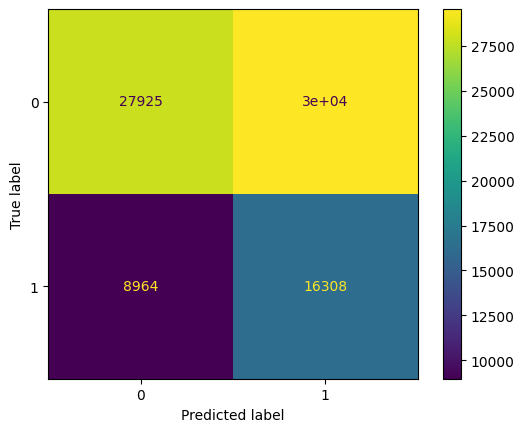

In [33]:
rf_grid_search.fit(X_train_oversampled,y_train_oversampled)

print('Random Forest Test Accuracy: {}'.format( rf_grid_search.score(X_test,y_test)))
print('Random Forest Best Params: {}'.format( rf_grid_search.best_params_))

best_rf = rf_grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

LR Test Accuracy: 0.6143267999129951
LR Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.74      0.68      0.71     57482
           1       0.39      0.46      0.42     25272

    accuracy                           0.61     82754
   macro avg       0.57      0.57      0.57     82754
weighted avg       0.63      0.61      0.62     82754



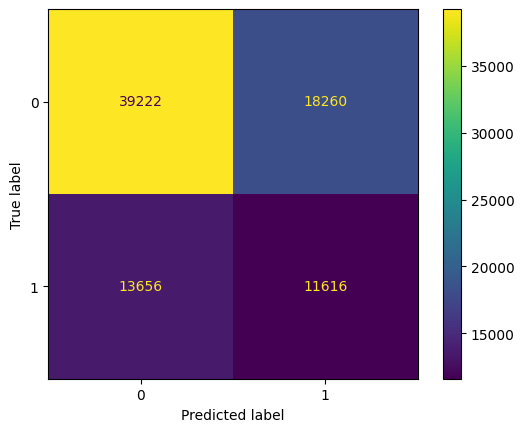

In [34]:
lr_grid_search.fit(X_train_oversampled,y_train_oversampled)

print('LR Test Accuracy: {}'.format( lr_grid_search.score(X_test,y_test)))
print('LR Best Params: {}'.format( lr_grid_search.best_params_))

best_lr = lr_grid_search.best_estimator_

y_pred = best_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

KNN Test Accuracy: 0.5781351958817701
KNN Best Params: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.70      0.68      0.69     57482
           1       0.32      0.35      0.33     25272

    accuracy                           0.58     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.58      0.58     82754



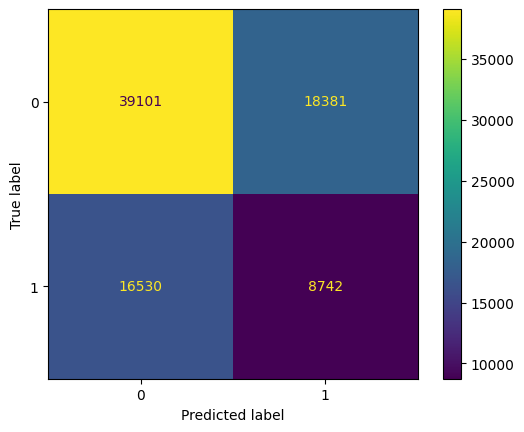

In [37]:

knn_grid_search.fit(X_train_oversampled,y_train_oversampled)

print('KNN Test Accuracy: {}'.format( knn_grid_search.score(X_test,y_test)))
print('KNN Best Params: {}'.format( knn_grid_search.best_params_))

best_knn = knn_grid_search.best_estimator_

y_pred = best_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

DT Test Accuracy: 0.6123087705730237
DT Best Params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 3}
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     57482
           1       0.38      0.45      0.41     25272

    accuracy                           0.61     82754
   macro avg       0.56      0.57      0.56     82754
weighted avg       0.63      0.61      0.62     82754



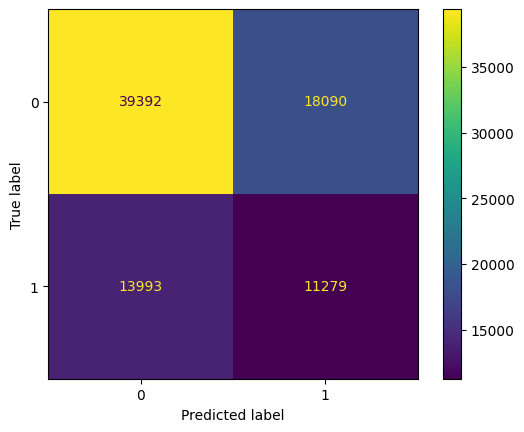

In [38]:
clf_dt =  DecisionTreeClassifier(random_state=42)

dt_param_grid = [{'criterion': ['gini', 'entropy'],
                   'min_samples_leaf': param_range,
                   'max_depth': param_range,
                   'min_samples_split': param_range[1:]}]

dt_grid_search = GridSearchCV(estimator=clf_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=3)

dt_grid_search.fit(X_train_oversampled,y_train_oversampled)

print('DT Test Accuracy: {}'.format( dt_grid_search.score(X_test,y_test)))
print('DT Best Params: {}'.format( dt_grid_search.best_params_))

best_dt = dt_grid_search.best_estimator_

y_pred = best_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
svm_param_grid = svm.SVC(kernel = 'rbf', random_state=46)

'''
clf_svm = svm.SVC(kernel = 'rbf', random_state=46)
svm_param_grid = [{'kernel': ['linear', 'rbf'],
                    'C': param_range[:1]}]

svm_grid_search = GridSearchCV(estimator=clf_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=3)
'''
svm_grid_search.fit(X_train_oversampled,y_train_oversampled)
best_svm = svm_grid_search.best_estimator_

print('SVM Test Accuracy: {}'.format( svm_grid_search.score(X_test,y_test)))
print('SVM Best Params: {}'.format( svm_grid_search.best_params_))



y_pred = best_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();